# Seguro Saúde - Feature Importance

### Carregando bibliotecas

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict

# check xgboost version
from xgboost import XGBRegressor

from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/datasetn/BaseTeste_DataScience.xlsx
/kaggle/input/datasetn/Seguro Sade - Modelagem.xlsx
/kaggle/input/datasetn/Seguro Sade - Teste Final.xlsx


### Funções

In [2]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

***
# 1) Definição do problema e objetivo do projeto

Uma administradora de planos de saúde precisa desenvolver um modelo preditivo que estima o custo médio anual gasto por cliente. 

Sua missão será de desenvolver uma modelagem preditiva baseada em algumas informações cadastrais. 

A administradora tem em mãos uma base de teste para posterior avaliação de performance da sua modelagem final.

O resultado de seu estudo será encaminhado para as áreas de negócio para validação funcional.

## 1.1) Dicionario de dados

In [3]:
dicionario = pd.read_excel('/kaggle/input/datasetn/Seguro Sade - Modelagem.xlsx', sheet_name='DICIONÁRIO')
dicionario

,MATRICULA,Matrícula do Cliente
0,IDADE,Idade do Cliente
1,NASCIMENTO,Data de Nascimento do Cliente
2,SEXO,Sexo do Cliente
3,IMC,IMC do Cliente
4,FILHOS,Quantidade de filhos do Cliente
5,FUMANTE,Se o Cliente fuma ou não
6,SIGNO,Signo do Cliente
7,REGIÃO,Região de Moradia do Cliente
8,FACEBOOK,Se o Cliente possui conta do Facebook ou não
9,CLASSE,Segmentação Atual do Cliente


***
# 2) Coleta e preparação dos dados

## 2.1) Coleta dos dados - Modelagem 90,51% do total

In [4]:
# treinamento
df = pd.read_excel('/kaggle/input/datasetn/Seguro Sade - Modelagem.xlsx', sheet_name='MODELAGEM')
df

,MATRICULA,IDADE,NASCIMENTO,SEXO,IMC,FILHOS,FUMANTE,SIGNO,REGIÃO,FACEBOOK,CLASSE,VALOR
0,207,56.0,1963-12-31,M,39.600,0.0,0.0,Capricórnio,3.0,0.0,7.0,3242.022018
1,852,32.0,1987-10-16,F,37.145,3.0,0.0,Libra,2.0,1.0,2.0,1937.108119
2,463,47.0,1973-01-23,F,24.100,1.0,0.0,Aquário,3.0,1.0,7.0,8023.418951
3,628,41.0,1979-01-08,M,30.780,3.0,1.0,Capricórnio,2.0,1.0,6.0,12109.298838
4,1100,23.0,1996-10-07,M,37.100,3.0,0.0,Libra,3.0,1.0,4.0,1100.182263
...,...,...,...,...,...,...,...,...,...,...,...,...
1206,71,61.0,1958-05-26,F,36.385,1.0,1.0,Gêmeos,2.0,0.0,10.0,14837.175275
1207,1198,20.0,2000-02-11,F,31.920,0.0,0.0,Aquário,4.0,1.0,5.0,691.611254
1208,983,27.0,1992-06-04,F,36.080,0.0,1.0,Gêmeos,1.0,1.0,10.0,11355.932171
1209,299,52.0,1967-05-15,M,32.775,3.0,0.0,Touro,4.0,0.0,1.0,3452.326988


### Checar dados faltantes

In [5]:
just_check_nan(df)

Dados com NaN:
IDADE         5
NASCIMENTO    8
SEXO          7
IMC           5
FILHOS        8
FUMANTE       8
SIGNO         6
REGIÃO        6
FACEBOOK      3
CLASSE        5
dtype: int64

columns_with_nan.shape (10,)



### Apagando dados faltantes

No caso deste problema, como a quantidade de dados faltantes é pouco com relação ao total, optei por deletar os faltantes.

O ideal é averiguar o motivo dos dados faltantes, e se mesmo assim persistir a falta, podemos:

   - Fill nos dados faltantes com:
       - Valores fixos
       - Valores medios
       - Previsão


In [6]:
df_dropped = df.dropna().reset_index(drop=True)

### Checando novamente dados faltantes

In [7]:
just_check_nan(df_dropped)

Dados com NaN:
Series([], dtype: int64)

columns_with_nan.shape (0,)



In [8]:
df_dropped

,MATRICULA,IDADE,NASCIMENTO,SEXO,IMC,FILHOS,FUMANTE,SIGNO,REGIÃO,FACEBOOK,CLASSE,VALOR
0,207,56.0,1963-12-31,M,39.600,0.0,0.0,Capricórnio,3.0,0.0,7.0,3242.022018
1,852,32.0,1987-10-16,F,37.145,3.0,0.0,Libra,2.0,1.0,2.0,1937.108119
2,463,47.0,1973-01-23,F,24.100,1.0,0.0,Aquário,3.0,1.0,7.0,8023.418951
3,628,41.0,1979-01-08,M,30.780,3.0,1.0,Capricórnio,2.0,1.0,6.0,12109.298838
4,1100,23.0,1996-10-07,M,37.100,3.0,0.0,Libra,3.0,1.0,4.0,1100.182263
...,...,...,...,...,...,...,...,...,...,...,...,...
1155,369,50.0,1969-08-24,M,32.300,2.0,0.0,Virgem,3.0,1.0,7.0,2945.075535
1156,71,61.0,1958-05-26,F,36.385,1.0,1.0,Gêmeos,2.0,0.0,10.0,14837.175275
1157,1198,20.0,2000-02-11,F,31.920,0.0,0.0,Aquário,4.0,1.0,5.0,691.611254
1158,983,27.0,1992-06-04,F,36.080,0.0,1.0,Gêmeos,1.0,1.0,10.0,11355.932171


## 2.2) Preparação dos dados

### Feature Importance - Criado em outro notebook

### Seleção de Features

In [9]:
df_dropped.columns

Index(['MATRICULA', 'IDADE', 'NASCIMENTO', 'SEXO', 'IMC', 'FILHOS', 'FUMANTE',
       'SIGNO', 'REGIÃO', 'FACEBOOK', 'CLASSE', 'VALOR'],
      dtype='object')

In [10]:
X = df_dropped[['IDADE', 'SEXO', 'IMC', 'FILHOS', 'FUMANTE',
                'SIGNO', 'REGIÃO', 'FACEBOOK', 'CLASSE']]
X

,IDADE,SEXO,IMC,FILHOS,FUMANTE,SIGNO,REGIÃO,FACEBOOK,CLASSE
0,56.0,M,39.600,0.0,0.0,Capricórnio,3.0,0.0,7.0
1,32.0,F,37.145,3.0,0.0,Libra,2.0,1.0,2.0
2,47.0,F,24.100,1.0,0.0,Aquário,3.0,1.0,7.0
3,41.0,M,30.780,3.0,1.0,Capricórnio,2.0,1.0,6.0
4,23.0,M,37.100,3.0,0.0,Libra,3.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...
1155,50.0,M,32.300,2.0,0.0,Virgem,3.0,1.0,7.0
1156,61.0,F,36.385,1.0,1.0,Gêmeos,2.0,0.0,10.0
1157,20.0,F,31.920,0.0,0.0,Aquário,4.0,1.0,5.0
1158,27.0,F,36.080,0.0,1.0,Gêmeos,1.0,1.0,10.0


### Seleção do Target

In [11]:
# define target
y = df_dropped['VALOR']

### Variaveis Categoricas

In [12]:
# Criando uma lista de variaveis categoricas
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

Categorical variables:  2
['SEXO', 'SIGNO']


In [13]:
X['SEXO'].unique()

array(['M', 'F'], dtype=object)

In [14]:
X['SIGNO'].unique()

array(['Capricórnio', 'Libra', 'Aquário', 'Virgem', 'Câncer', 'Gêmeos',
       'Leão', 'Escorpião', 'Peixes', 'Áries', 'Touro', 'Sagitário'],
      dtype=object)

### Variaveis Numéricas

In [15]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

Numerical variables:  7
['IDADE', 'IMC', 'FILHOS', 'FUMANTE', 'REGIÃO', 'FACEBOOK', 'CLASSE']


***
# 3) Modelagem dos dados

## StandardScaler

In [16]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

## Dividindo as features em dados de treino e validação

In [17]:
# Dividindo as features em dados de treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.7, 
                                                  random_state = 2048)

In [18]:
# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_val.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(label_X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.fit_transform(label_X_valid[object_cols])

model = GradientBoostingRegressor(random_state=2048)
model.fit(label_X_train, y_train)
preds = cross_val_predict(model, label_X_valid, y_val, n_jobs=-1, cv=5)

***
### Feature Importance

In [19]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, n_iter=100).fit(label_X_valid, y_val)
eli5.show_weights(perm, feature_names = label_X_valid.columns.tolist())

Weight,Feature
1.3988 ± 0.1174,FUMANTE
0.2780 ± 0.0468,IMC
0.1992 ± 0.0240,IDADE
0.0129 ± 0.0063,FILHOS
0.0006 ± 0.0017,FACEBOOK
-0.0002 ± 0.0006,SEXO
-0.0003 ± 0.0012,REGIÃO
-0.0012 ± 0.0034,SIGNO
-0.0019 ± 0.0026,CLASSE


Importância do recurso: as variáveis são classificadas em ordem decrescente.

Impacto: A localização horizontal mostra se o efeito desse valor está associado a uma previsão maior ou menor.

Valor original: A cor mostra se aquela variável é alta (em vermelho) ou baixa (em azul) para aquela observação.

Correlação: Um alto nível de teor de “álcool” tem um impacto alto e positivo na classificação de qualidade. O “alto” vem da cor vermelha e o impacto “positivo” é mostrado no eixo X. Da mesma forma, diremos que a “acidez volátil” está negativamente correlacionada com a variável alvo.

***
### SHAP Values

Exact explainer: 813it [00:36, 18.46it/s]                         


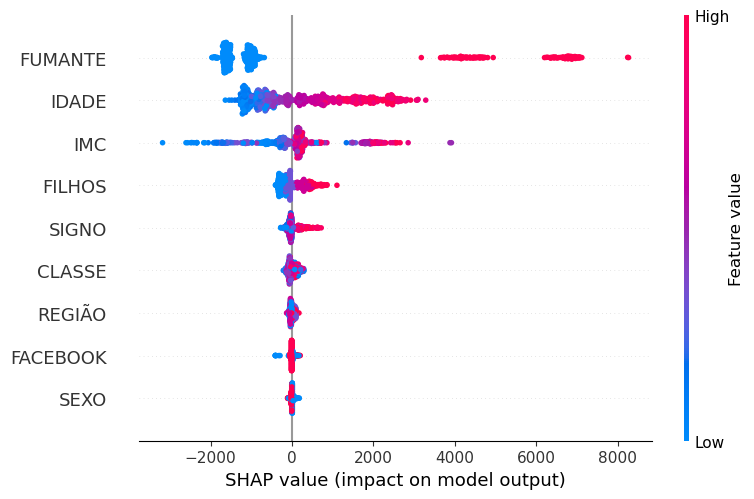

In [20]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.Explainer(model.predict, label_X_valid)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer(label_X_valid)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, label_X_valid)